# Model Training: Higgs Boson Classification

This notebook trains neural network models for Higgs boson classification.

In [1]:
import sys
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt

from data_loader import load_higgs_data, get_data_loaders
from models import create_model
from trainer import Trainer
from visualization import plot_training_history, plot_roc_curve, plot_confusion_matrix, plot_prediction_distribution

%matplotlib inline

## Configuration

In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Training configuration
config = {
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 50,
    'early_stopping_patience': 10,
    'model_type': 'simple'  # 'simple', 'standard', or 'deep'
}

Using device: cpu


## Load and Prepare Data

In [3]:
# Load data
X_train, X_test, y_train, y_test = load_higgs_data(
    data_path='../data/HIGGS.csv',
    n_samples=50000,
    test_split=0.2,
    random_seed=42
)

# Create data loaders
train_loader, val_loader, test_loader = get_data_loaders(
    X_train, X_test, y_train, y_test,
    batch_size=config['batch_size'],
    val_split=0.1
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Loading data from ../data/HIGGS.csv...
Loaded 40000 training samples and 10000 test samples
Number of features: 28
Class distribution - Train: 53.21% signal
Class distribution - Test: 52.82% signal
Training batches: 282
Validation batches: 32
Test batches: 79


## Create Model

In [4]:
# Create model
input_dim = X_train.shape[1]
model = create_model(
    model_type=config['model_type'],
    input_dim=input_dim
)

print(f"Model: {config['model_type']}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"\nModel architecture:")
print(model)

Model: simple
Number of parameters: 4161

Model architecture:
SimpleHiggsClassifier(
  (fc1): Linear(in_features=28, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Train Model

In [5]:
# Create trainer
trainer = Trainer(
    model=model,
    device=device,
    learning_rate=config['learning_rate']
)

# Train
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=config['epochs'],
    early_stopping_patience=config['early_stopping_patience'],
    verbose=True
)

Epoch 1/50:
  Train Loss: 0.6580, Train Acc: 0.6026
  Val Loss: 0.6302, Val Acc: 0.6385
Epoch 2/50:
  Train Loss: 0.6280, Train Acc: 0.6443
  Val Loss: 0.6155, Val Acc: 0.6538
Epoch 3/50:
  Train Loss: 0.6144, Train Acc: 0.6621
  Val Loss: 0.6050, Val Acc: 0.6683
Epoch 4/50:
  Train Loss: 0.6048, Train Acc: 0.6716
  Val Loss: 0.5963, Val Acc: 0.6817
Epoch 5/50:
  Train Loss: 0.5973, Train Acc: 0.6799
  Val Loss: 0.5889, Val Acc: 0.6915
Epoch 6/50:
  Train Loss: 0.5916, Train Acc: 0.6820
  Val Loss: 0.5832, Val Acc: 0.6947
Epoch 7/50:
  Train Loss: 0.5869, Train Acc: 0.6858
  Val Loss: 0.5797, Val Acc: 0.6957
Epoch 8/50:
  Train Loss: 0.5807, Train Acc: 0.6943
  Val Loss: 0.5751, Val Acc: 0.6955
Epoch 9/50:
  Train Loss: 0.5806, Train Acc: 0.6946
  Val Loss: 0.5715, Val Acc: 0.6985
Epoch 10/50:
  Train Loss: 0.5761, Train Acc: 0.6963
  Val Loss: 0.5686, Val Acc: 0.7017
Epoch 11/50:
  Train Loss: 0.5737, Train Acc: 0.6984
  Val Loss: 0.5645, Val Acc: 0.7065
Epoch 12/50:
  Train Loss: 0.5

## Visualize Training History

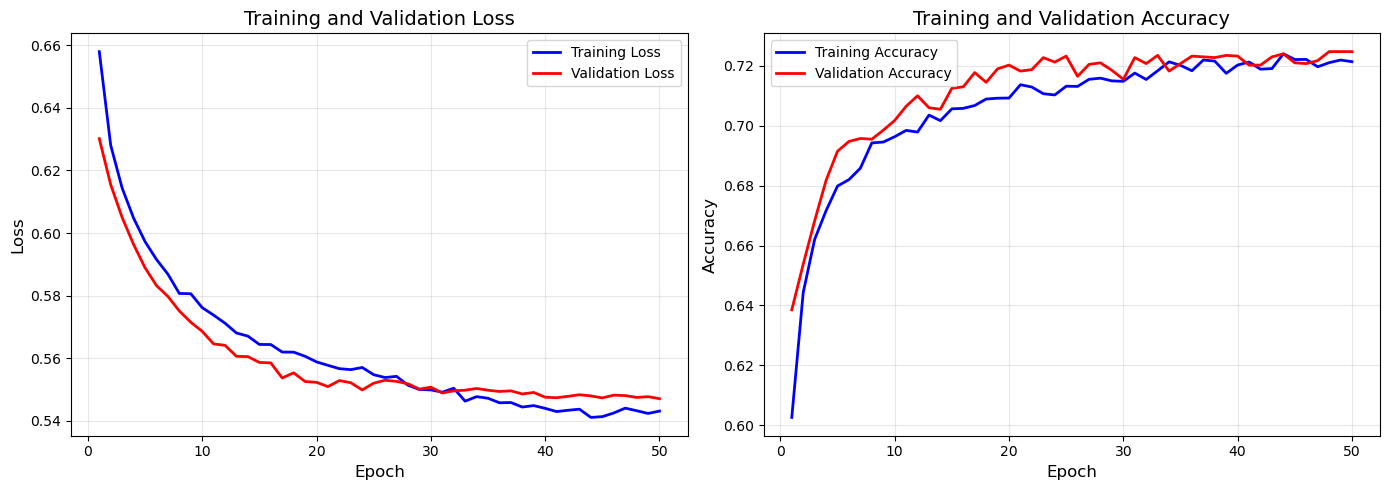

In [6]:
plot_training_history(
    history,
    save_path='../figures/training_history.png'
)

## Evaluate on Test Set

In [7]:
# Evaluate
metrics = trainer.evaluate(test_loader)

print("Test Set Performance:")
print(f"  Accuracy: {metrics['accuracy']:.4f}")
print(f"  Precision: {metrics['precision']:.4f}")
print(f"  Recall: {metrics['recall']:.4f}")
print(f"  F1 Score: {metrics['f1_score']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Positives: {metrics['tp']}")
print(f"  False Positives: {metrics['fp']}")
print(f"  True Negatives: {metrics['tn']}")
print(f"  False Negatives: {metrics['fn']}")

Test Set Performance:
  Accuracy: 0.5014
  Precision: 0.5282
  Recall: 0.5257
  F1 Score: 0.5269

Confusion Matrix:
  True Positives: 27767474
  False Positives: 24802526
  True Negatives: 22377474
  False Negatives: 25052526


## Get Predictions

In [8]:
# Get predictions on test set
model.eval()
y_pred_probs = []
y_pred_labels = []
y_true_all = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model(data)
        probs = outputs.cpu().numpy()
        y_pred_probs.extend(probs)
        y_pred_labels.extend((probs >= 0.5).astype(int))
        y_true_all.extend(target.numpy())

y_pred_probs = np.array(y_pred_probs).flatten()
y_pred_labels = np.array(y_pred_labels).flatten()
y_true_all = np.array(y_true_all).flatten()

## ROC Curve

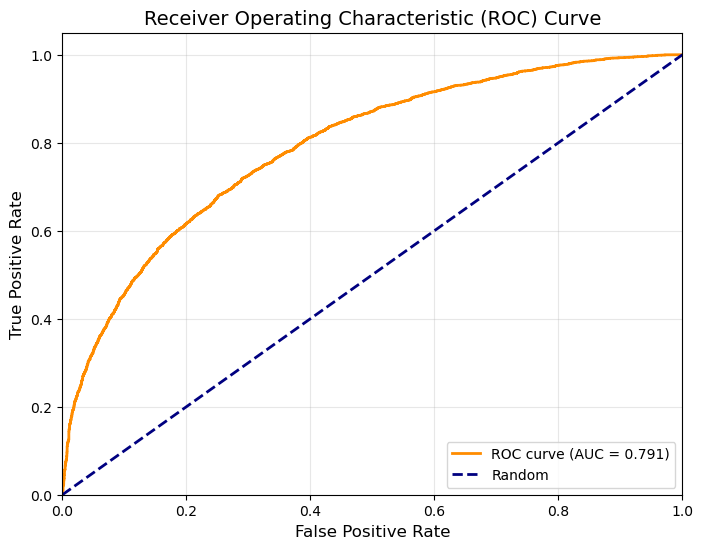

AUC Score: 0.7908


In [9]:
auc_score = plot_roc_curve(
    y_true_all,
    y_pred_probs,
    save_path='../figures/roc_curve.png'
)
print(f"AUC Score: {auc_score:.4f}")

## Confusion Matrix

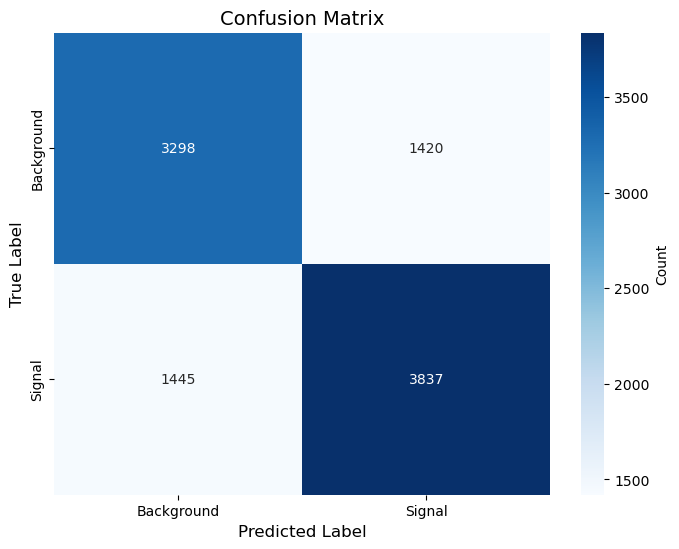

In [10]:
plot_confusion_matrix(
    y_true_all,
    y_pred_labels,
    save_path='../figures/confusion_matrix.png'
)

## Prediction Distribution

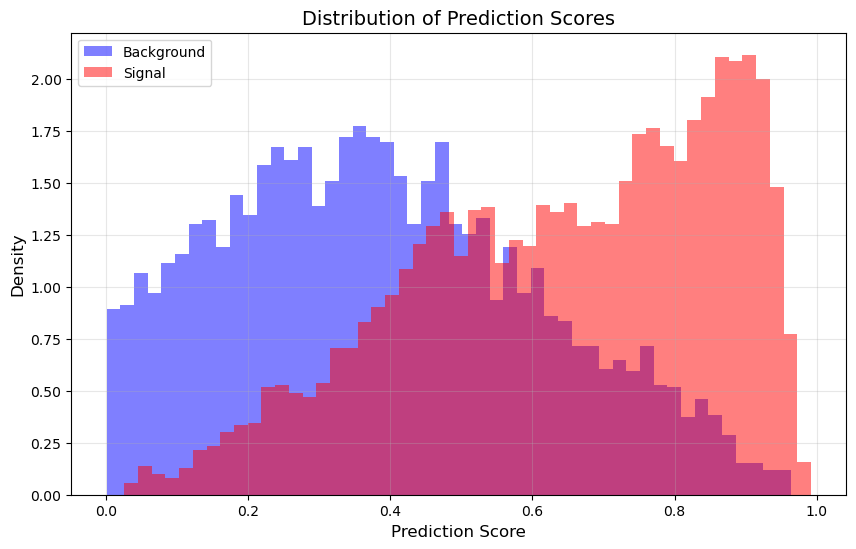

In [11]:
plot_prediction_distribution(
    y_true_all,
    y_pred_probs,
    save_path='../figures/prediction_distribution.png'
)

## Save Model

In [12]:
# Save model
model_path = f"../models/higgs_classifier_{config['model_type']}.pth"
trainer.save_model(model_path)

Model saved to ../models/higgs_classifier_simple.pth
